# Visualize drug data
**Author:** Scott Campit

In [1]:
from dash import Dash, dash_table, dcc, html
from jupyter_dash import JupyterDash
import plotly
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

## Summary
This notebook visualizes the drug data to identify potential drug/metabolite pairs that reduce cell count significantly. From here, these drug/metabolite pairs will be referred to as "hits".

## 1. Load Data

In [2]:
path = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/raw/assay_results.xlsx"
gsk = pd.read_excel(path, 
                    sheet_name='08_15_22_GSK', 
                    engine='openpyxl')
vorino = pd.read_excel(path, 
                    sheet_name='08_15_22_Vorinostat', 
                    engine='openpyxl')

In [3]:
gsk['Metabolite concentration'] = gsk['Metabolite concentration'].fillna(0)
vorino['Metabolite concentration'] = vorino['Metabolite concentration'].fillna(0)

In [4]:
gsk['Drug concentration'] = gsk['Drug concentration'].fillna(0)
vorino['Drug concentration'] = vorino['Drug concentration'].fillna(0)

In [5]:
vorino.tail(5)

,Drug,Metabolite,N,Metabolite concentration,Drug concentration,Cell Count
379,Vorinostat,Water,6,0.0,2.56,220140
380,Vorinostat,Water,6,0.0,1.11,301770
381,Vorinostat,Water,6,0.0,0.48,354980
382,Vorinostat,Water,6,0.0,0.21,355240
383,Vorinostat,Water,6,0.0,0.09,241860


First, let's get the DMSO and water only samples as the double negative control.

In [6]:
gsk_dmso = gsk.loc[gsk["Metabolite"].str.contains("Water") & 
                   gsk["Drug"].str.contains("DMSO")]
vorino_dmso = vorino.loc[vorino["Metabolite"].str.contains("Water") & 
                   vorino["Drug"].str.contains("DMSO")]

Visualize the distribution.

<AxesSubplot:xlabel='N', ylabel='Cell Count'>

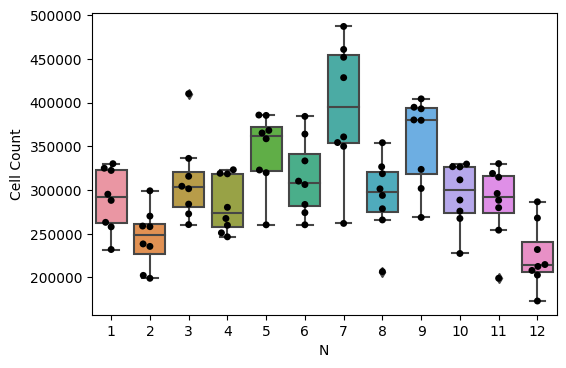

In [7]:
plt.figure(dpi=100)
sns.boxplot(data=gsk_dmso, x='N', y='Cell Count')
sns.swarmplot(data=gsk_dmso, x='N', y='Cell Count', edgecolor='black', color='black')

<AxesSubplot:xlabel='N', ylabel='Cell Count'>

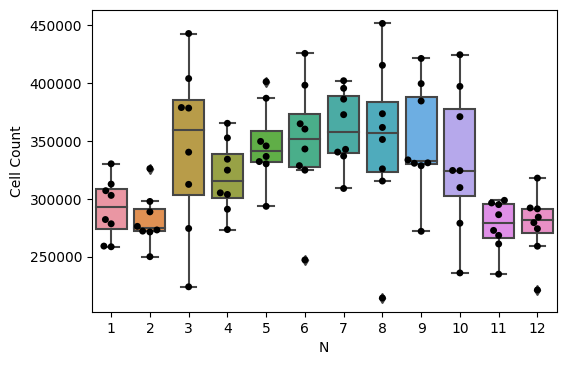

In [8]:
plt.figure(dpi=100)
sns.boxplot(data=vorino_dmso, x='N', y='Cell Count')
sns.swarmplot(data=vorino_dmso, x='N', y='Cell Count', edgecolor='black', color='black')

Next, let's get the drug with water samples as another control.

In [9]:
gsk_only = gsk.loc[gsk["Metabolite"].str.contains("Water") & 
                   gsk["Drug"].str.contains("GSK-J4")]
vorino_only = vorino.loc[vorino["Metabolite"].str.contains("Water") & 
                   vorino["Drug"].str.contains("Vorinostat")]

<AxesSubplot:xlabel='N', ylabel='Cell Count'>

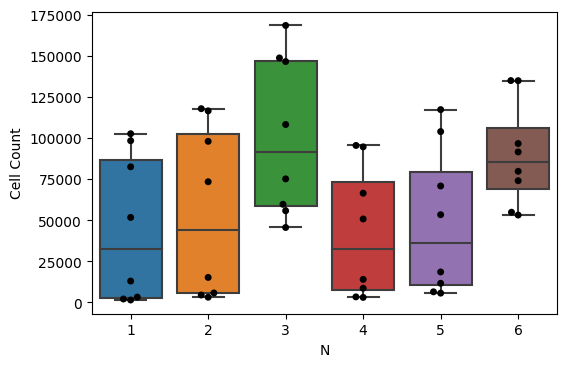

In [10]:
plt.figure(dpi=100)
sns.boxplot(data=gsk_only, x='N', y='Cell Count')
sns.swarmplot(data=gsk_only, x='N', y='Cell Count', edgecolor='black', color='black')

<AxesSubplot:xlabel='N', ylabel='Cell Count'>

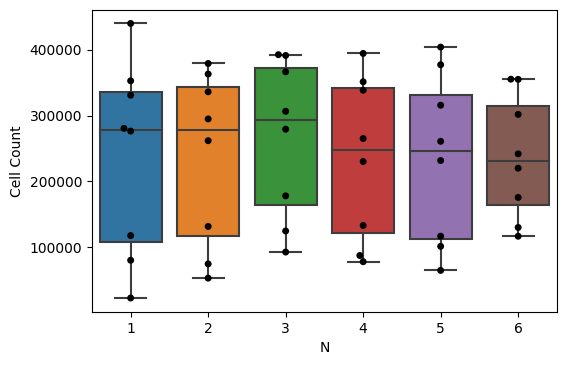

In [11]:
plt.figure(dpi=100)
sns.boxplot(data=vorino_only, x='N', y='Cell Count')
sns.swarmplot(data=vorino_only, x='N', y='Cell Count', edgecolor='black', color='black')

## 2. Preprocess Data

We'll normalize the data in two ways. One way will be to normalize against DMSO and water only. The other way we'll normalize is with the drug treatment only.

The function below does the following:
  * **Aggregates cell counts (mean aggregation)** by metabolite, metabolite concentration, and drug concentration.
  * **Calculates the normalized cell count** values, which is the average cell count (treatment) / control.
    * If there are multiple drug dose values in the control, the function automatically divides by the correct dose (e.g 1uM treatment / 1uM control)
  * Returns the normalized count as **% viability**. Negative values indicate less viability. Positive values indicate enhanced survival.
  * Returns the **T-score, p-value, and FDR** of two indpendent samples (treatment/control comparison).
    * The threshold for FDR used was assumed to be 0.05.  

In [12]:
def calcTstatistics(data:pd.DataFrame, controlAverage:float, alpha=0.05):
    """Calculates statistics from T-test and performs data preprocessing."""
    all_mets = list()
    met_concs = list()
    drug_concs = list()
    tx_cell_counts = list()
    ct_cell_counts = list()
    norm_cell_counts = list()
    pct_inhibition = list()
    tscores = list()
    pvalues = list()

    for drug in data['Drug'].unique():
        if drug == 'DMSO':
            pass
        else:
            for metabolite in data['Metabolite'].unique():
                if metabolite == 'Water':
                    pass
                else:
                    for met_conc in data['Metabolite concentration'].unique():
                        if met_conc == 0:
                            pass
                        else:
                            for drug_conc in data['Drug concentration'].unique():
                                if drug_conc == 0:
                                    pass
                                else:
                                    tmp_df = data.loc[
                                        (data['Metabolite'] == metabolite) &
                                        (data['Metabolite concentration'] == met_conc) &
                                        (data['Drug concentration'] == drug_conc)
                                    ]

                                    # size of control data varies. If DMSO, single scalar. If +drug only, contains multiple drug doses.
                                    if isinstance(controlAverage, np.float64):
                                        tmp_control = controlAverage * np.ones(tmp_df.shape[0])
                                    else:
                                        tmp_control = controlAverage.loc[drug_conc] * np.ones(tmp_df.shape[0])
                            
                                    # Normalization, % viability, and T-test
                                    tmp_df['Normalized Counts (treatment/control)'] = tmp_df['Cell Count'] / tmp_control
                                    t, p = ttest_ind(tmp_df['Cell Count'], tmp_control, equal_var=False)
                                    tmp_df['% viability'] = (tmp_df['Normalized Counts (treatment/control)']-1) * 100

                                    # Store all data for final aggregation
                                    all_mets.append(metabolite)
                                    met_concs.append(met_conc)
                                    drug_concs.append(drug_conc)
                                    tx_cell_counts.append(int(tmp_df['Cell Count'].mean()))
                                    norm_cell_counts.append(tmp_df['Normalized Counts (treatment/control)'].mean())
                                    pct_inhibition.append(tmp_df['% viability'].mean())
                                    if isinstance(controlAverage, np.float64):
                                        ct_cell_counts.append(int(controlAverage))
                                    else:
                                        ct_cell_counts.append(int(controlAverage.loc[drug_conc]))
                                    tscores.append(t)
                                    pvalues.append(p)

    return pd.DataFrame({
                            'Metabolite': all_mets,
                            'Metabolite concentration': met_concs,
                            'Drug concentration': drug_concs,
                            'Average cell count (treatment)': tx_cell_counts,
                            'Average cell count (control)': ct_cell_counts,
                            'Normalized Counts (treatment/control)': norm_cell_counts, 
                            '% viability': pct_inhibition, 
                            'T-score': tscores, 
                            'p-value': pvalues,
                            'FDR': fdrcorrection(np.array(pvalues), is_sorted=False, alpha=alpha)[1].tolist()
                        })


Calculate the statistics using the cell counts. The control is DMSO/water.

In [13]:
gskDMSOaverage = gsk_dmso['Cell Count'].mean()
gskDMSOAverageDF = calcTstatistics(gsk, gskDMSOaverage)
gskDMSOAverageDF['Drug'] = 'GSK-J4'
gskDMSOAverageDF.head(5)

C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Normalized Counts (treatment/control)'] = tmp_df['Cell Count'] / tmp_control
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['% viability'] = (tmp_df['Normalized Counts (treatment/control)']-1) * 100
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.0,41880,303017,0.138210,-86.179011,-27.929133,0.022784,0.029399,GSK-J4
1,Sorbitol,2000.0,71.4,38955,303017,0.128557,-87.144302,-186.616534,0.003411,0.009729,GSK-J4
2,Sorbitol,2000.0,51.0,34045,303017,0.112353,-88.764671,-250.206880,0.002544,0.008195,GSK-J4
3,Sorbitol,2000.0,36.4,39145,303017,0.129184,-87.081600,-182.610655,0.003486,0.009729,GSK-J4
4,Sorbitol,2000.0,26.0,56255,303017,0.185649,-81.435059,-41.507552,0.015334,0.023195,GSK-J4


In [14]:
controlDMSODF = gskDMSOAverageDF.copy()
controlDMSODF['Average cell count (treatment)'] = controlDMSODF['Average cell count (control)']
controlDMSODF['Average cell count (treatment)'] = controlDMSODF['Average cell count (control)']


In [15]:
vorinoDMSOaverage = vorino_dmso['Cell Count'].mean()
vorinoDMSOAverageDF = calcTstatistics(vorino, vorinoDMSOaverage)
vorinoDMSOAverageDF['Drug'] = 'Vorinostat'

vorinoDMSOAverageDF.head(5)

C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Normalized Counts (treatment/control)'] = tmp_df['Cell Count'] / tmp_control
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['% viability'] = (tmp_df['Normalized Counts (treatment/control)']-1) * 100
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,31.25,96255,323552,0.297494,-70.250606,-6.167353,0.102334,0.205453,Vorinostat
1,Sorbitol,2000.0,13.58,90445,323552,0.279537,-72.046295,-35.890348,0.017733,0.084504,Vorinostat
2,Sorbitol,2000.0,5.90,160085,323552,0.494772,-50.522760,-11.564755,0.054912,0.163579,Vorinostat
3,Sorbitol,2000.0,2.56,263590,323552,0.814674,-18.532620,-2.992156,0.205333,0.320000,Vorinostat
4,Sorbitol,2000.0,1.11,373985,323552,1.155870,15.587003,1.070861,0.478225,0.567130,Vorinostat


In [16]:
DMSOWaterDF = pd.concat([gskDMSOAverageDF, vorinoDMSOAverageDF])
DMSOWaterDF.head(3)

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.0,41880,303017,0.138210,-86.179011,-27.929133,0.022784,0.029399,GSK-J4
1,Sorbitol,2000.0,71.4,38955,303017,0.128557,-87.144302,-186.616534,0.003411,0.009729,GSK-J4
2,Sorbitol,2000.0,51.0,34045,303017,0.112353,-88.764671,-250.206880,0.002544,0.008195,GSK-J4


Now calculate the statistics using the drug/water as the control.

In [17]:
gskOnlyaverage = gsk_only.groupby(['Drug concentration'])['Cell Count'].mean()
gskOnlyAverageDF = calcTstatistics(gsk, gskOnlyaverage)
gskOnlyAverageDF['Drug'] = 'GSK-J4'
gskOnlyAverageDF.head(5)

C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Normalized Counts (treatment/control)'] = tmp_df['Cell Count'] / tmp_control
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['% viability'] = (tmp_df['Normalized Counts (treatment/control)']-1) * 100
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.0,41880,27086,1.546148,54.614817,1.582175,0.358829,0.388826,GSK-J4
1,Sorbitol,2000.0,71.4,38955,25021,1.556851,55.685073,9.846879,0.064431,0.154634,GSK-J4
2,Sorbitol,2000.0,51.0,34045,21100,1.613507,61.350711,12.041860,0.052746,0.134671,GSK-J4
3,Sorbitol,2000.0,36.4,39145,29746,1.315946,31.594576,6.504037,0.097120,0.211899,GSK-J4
4,Sorbitol,2000.0,26.0,56255,71486,0.786930,-21.307004,-2.562097,0.236900,0.305677,GSK-J4


In [18]:
vorinoOnlyaverage = vorino_only.groupby(['Drug concentration'])['Cell Count'].mean()
vorinoOnlyAverageDF = calcTstatistics(vorino, vorinoOnlyaverage)
vorinoOnlyAverageDF['Drug'] = 'Vorinostat'
vorinoOnlyAverageDF.head(5)

C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Normalized Counts (treatment/control)'] = tmp_df['Cell Count'] / tmp_control
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['% viability'] = (tmp_df['Normalized Counts (treatment/control)']-1) * 100
C:\Users\Scott\AppData\Local\Temp\ipykernel_3524\2413045389.py:42: SettingWithCopyWarning: 
A value is trying to be set

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,31.25,96255,81365,1.183003,18.300252,0.404016,0.755561,0.927222,Vorinostat
1,Sorbitol,2000.0,13.58,90445,89970,1.005280,0.527954,0.073133,0.953525,0.988665,Vorinostat
2,Sorbitol,2000.0,5.90,160085,142208,1.125708,12.570759,1.264709,0.425925,0.927222,Vorinostat
3,Sorbitol,2000.0,2.56,263590,249958,1.054536,5.453576,0.680223,0.619729,0.927222,Vorinostat
4,Sorbitol,2000.0,1.11,373985,308475,1.212367,21.236729,1.391018,0.396803,0.927222,Vorinostat


In [19]:
DrugOnlyDF = pd.concat([gskOnlyAverageDF, vorinoOnlyAverageDF])
DrugOnlyDF.head(3)

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.0,41880,27086,1.546148,54.614817,1.582175,0.358829,0.388826,GSK-J4
1,Sorbitol,2000.0,71.4,38955,25021,1.556851,55.685073,9.846879,0.064431,0.154634,GSK-J4
2,Sorbitol,2000.0,51.0,34045,21100,1.613507,61.350711,12.041860,0.052746,0.134671,GSK-J4


## 3. Visualization
Below is a function that will help visualize everything.

### A. Dose Response Curves

In [20]:
def make_static_dose_curve(df:pd.DataFrame, yaxis_label:str='Normalized cell counts', var_to_visualize=None, sharex=True, sharey=True, legend=True, norm_curve=False, hide_title=False):
    """
    Generates dose response curves given a single dataframe.
    """

    dash_list = sns._core.unique_dashes(df["Metabolite concentration"].unique().size+1)
    style = {key:value for key, value in zip(df["Metabolite concentration"].unique(), dash_list[1:])}

    if 0 in style:
        style[0] = '--'  

    with sns.axes_style("darkgrid"):
        g = sns.FacetGrid(df, 
                        col="Metabolite", row="Drug", 
                        hue="Metabolite concentration",
                        sharex=sharex, sharey=sharey,
                        palette="flare")

    g.map(sns.lineplot, 
        "Drug concentration", var_to_visualize, 
        ci='sd', marker='o', style="Metabolite concentration", dashes=style)
    
    for (row_key, col_key), ax in g.axes_dict.items():
        if hide_title:
            ax.set_title("")
        else:
            ax.set_title(f"{col_key}")
    
    g.set(xscale="log")
    
    g.set(xticks=df['Drug concentration'].unique(),
          xticklabels=df['Drug concentration'].unique())
    
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
        if norm_curve:
            axes.axhline(y=0, color='black')
    print(x for x in df["Drug"].unique())
    g.set_axis_labels(
        "[" + df["Drug"].unique()[0] + "]",
        yaxis_label
    )

    #g.axes[-1, 0].set_xlabel('['+df["Drug"].unique()[0]+']'+u" (\u03bcM)")
    #g.axes[-1, 1].set_xlabel('['+df["Drug"].unique()[1]+']'+u" (\u03bcM)")

    #g.axes[-1, 0].set_xscale('log')
    #g.axes[-1, 1].set_xscale('log')
    plt.tight_layout()
    if legend:
        g.add_legend()


In [21]:
DMSOWaterDF

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.00,41880,303017,0.138210,-86.179011,-27.929133,0.022784,0.029399,GSK-J4
1,Sorbitol,2000.0,71.40,38955,303017,0.128557,-87.144302,-186.616534,0.003411,0.009729,GSK-J4
2,Sorbitol,2000.0,51.00,34045,303017,0.112353,-88.764671,-250.206880,0.002544,0.008195,GSK-J4
3,Sorbitol,2000.0,36.40,39145,303017,0.129184,-87.081600,-182.610655,0.003486,0.009729,GSK-J4
4,Sorbitol,2000.0,26.00,56255,303017,0.185649,-81.435059,-41.507552,0.015334,0.023195,GSK-J4
...,...,...,...,...,...,...,...,...,...,...,...
115,Pantothenate,195.0,2.56,246605,323552,0.762179,-23.782149,-4.307182,0.145231,0.256127,Vorinostat
116,Pantothenate,195.0,1.11,313130,323552,0.967786,-3.221364,-0.577761,0.666470,0.720509,Vorinostat
117,Pantothenate,195.0,0.48,372125,323552,1.150121,15.012136,1.233579,0.433666,0.531019,Vorinostat
118,Pantothenate,195.0,0.21,394565,323552,1.219476,21.947634,0.953248,0.515235,0.583285,Vorinostat


In [22]:
tmp1 = DMSOWaterDF.loc[DMSOWaterDF['Drug'] == DMSOWaterDF['Drug'].unique()[0], :]
tmp2 = DMSOWaterDF.loc[DMSOWaterDF['Drug'] == DMSOWaterDF['Drug'].unique()[1], :]
tmp3 = DrugOnlyDF.loc[DrugOnlyDF['Drug'] == DrugOnlyDF['Drug'].unique()[0], :]
tmp4 = DrugOnlyDF.loc[DrugOnlyDF['Drug'] == DrugOnlyDF['Drug'].unique()[1], :]

In [50]:
tmp5 = tmp3.copy()
tmp5['Average cell count (treatment)'] = tmp5['Average cell count (control)']
tmp5['Metabolite concentration'] = 0
tmp6 = pd.concat([tmp3, tmp5])
tmp6

,Metabolite,Metabolite concentration,Drug concentration,Average cell count (treatment),Average cell count (control),Normalized Counts (treatment/control),% viability,T-score,p-value,FDR,Drug
0,Sorbitol,2000.0,100.00,41880,27086,1.546148,54.614817,1.582175,0.358829,0.388826,GSK-J4
1,Sorbitol,2000.0,71.40,38955,25021,1.556851,55.685073,9.846879,0.064431,0.154634,GSK-J4
2,Sorbitol,2000.0,51.00,34045,21100,1.613507,61.350711,12.041860,0.052746,0.134671,GSK-J4
3,Sorbitol,2000.0,36.40,39145,29746,1.315946,31.594576,6.504037,0.097120,0.211899,GSK-J4
4,Sorbitol,2000.0,26.00,56255,71486,0.786930,-21.307004,-2.562097,0.236900,0.305677,GSK-J4
...,...,...,...,...,...,...,...,...,...,...,...
115,Pantothenate,0.0,36.40,29746,29746,0.407777,-59.222322,-2.936111,0.208979,0.283940,GSK-J4
116,Pantothenate,0.0,26.00,71486,71486,0.541430,-45.857036,-7.579576,0.083509,0.185576,GSK-J4
117,Pantothenate,0.0,18.50,116728,116728,0.745363,-25.463683,-6.344361,0.099525,0.211981,GSK-J4
118,Pantothenate,0.0,13.20,121815,121815,0.842507,-15.749292,-5.358939,0.117445,0.220210,GSK-J4


In [44]:
tmp2['Metabolite concentration'].unique()

array([2000.,  625.,  195.])

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025384FDD510>


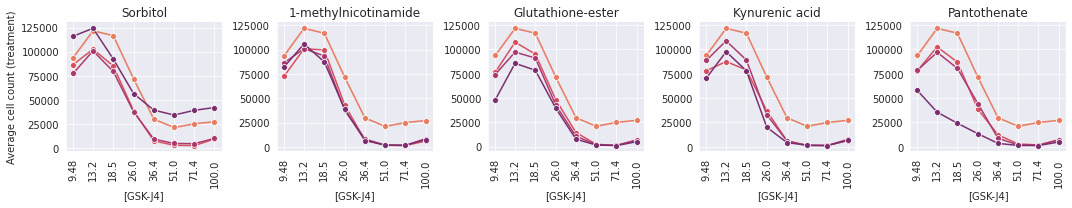

In [51]:
make_static_dose_curve(tmp6, 
                        yaxis_label='Average cell count (treatment)', 
                        var_to_visualize='Average cell count (treatment)',
                        sharex=False, sharey=False, legend=False)

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x00000253790BE270>


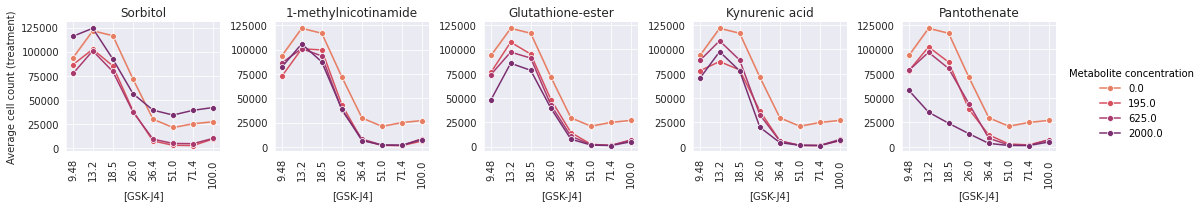

In [52]:
make_static_dose_curve(tmp6, 
                        yaxis_label='Average cell count (treatment)', 
                        var_to_visualize='Average cell count (treatment)',
                        sharex=False, sharey=False)

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x00000253790BEEB0>


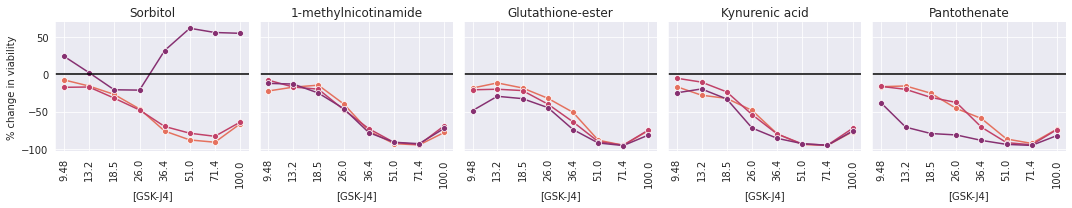

In [25]:
make_static_dose_curve(tmp3, 
                        yaxis_label='% change in viability', 
                        var_to_visualize='% viability',
                        sharex=False, sharey=True, legend=False, norm_curve=True)

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025385379580>


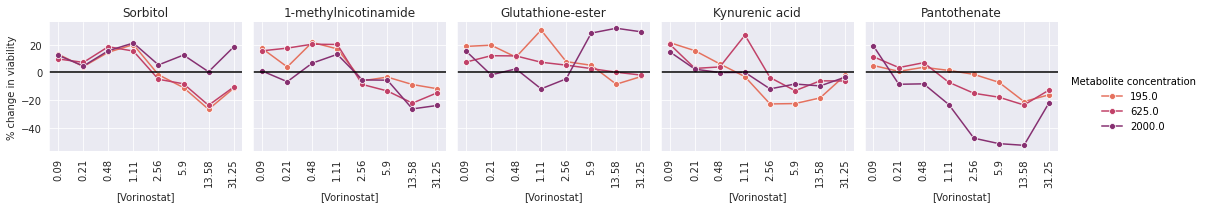

In [26]:
make_static_dose_curve(tmp4, 
                        yaxis_label='% change in viability', 
                        var_to_visualize='% viability',
                        sharex=False, sharey=True, norm_curve=True)

#### i. Average Cell Counts
First, visualize the average treatment cell count data. Below is the data with DMSO + water.

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025385379740>


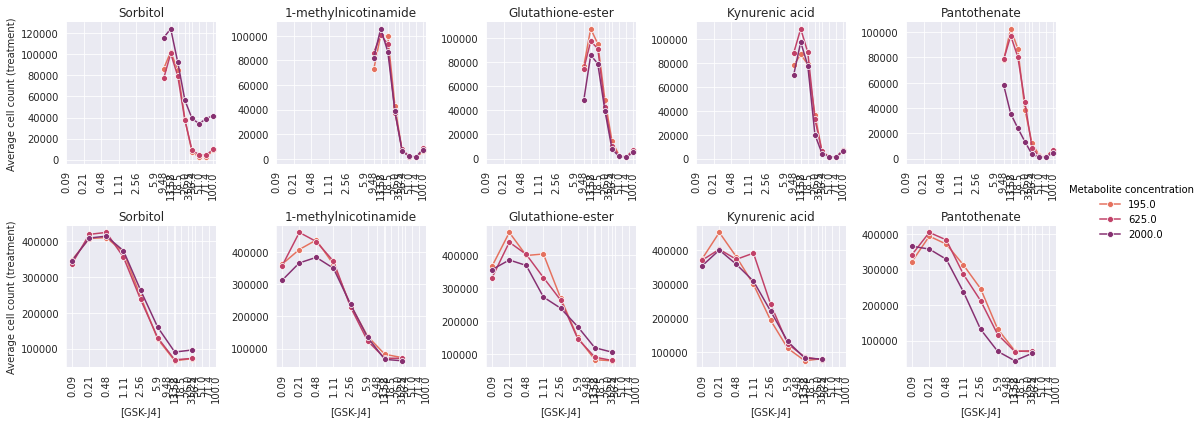

In [27]:
make_static_dose_curve(DMSOWaterDF, 
                        yaxis_label='Average cell count (treatment)', 
                        var_to_visualize='Average cell count (treatment)',
                        sharex=False, sharey=False)

Below is the data with drug only.

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025385379DD0>


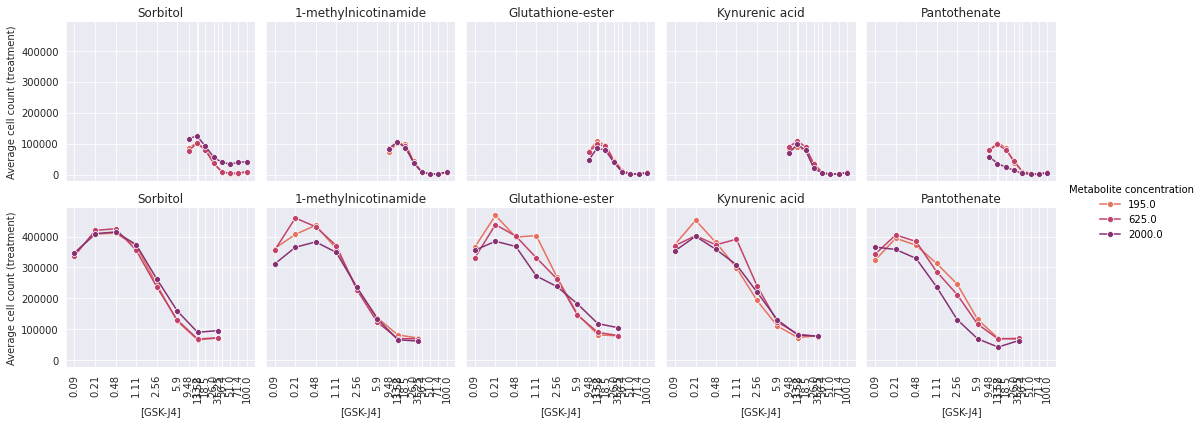

In [28]:
make_static_dose_curve(DrugOnlyDF, yaxis_label='Average cell count (treatment)', var_to_visualize='Average cell count (treatment)')

#### ii. Normalized Counts
We define normalized cell counts as average(treatment) / average(control). The bottom plot shows the control as DMSO + water

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x00000253790BE2E0>


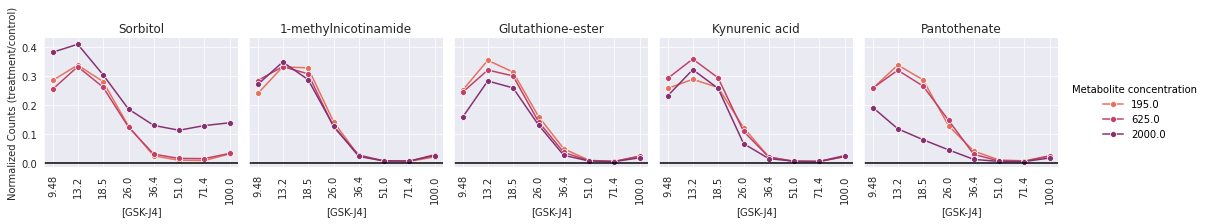

In [29]:
make_static_dose_curve(tmp1, yaxis_label='Normalized Counts (treatment/control)', var_to_visualize='Normalized Counts (treatment/control)', norm_curve=True, legend=True)

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025385379F90>


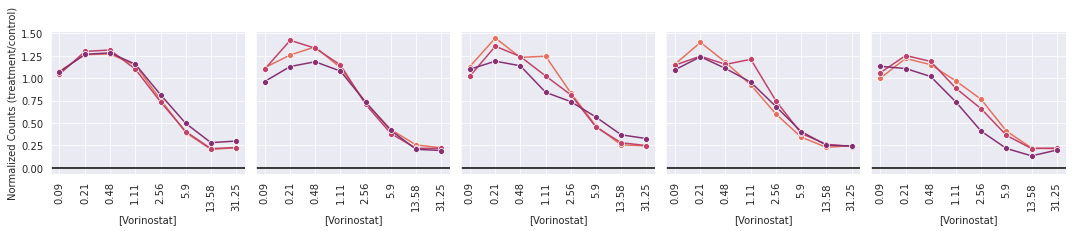

In [30]:
make_static_dose_curve(tmp2, yaxis_label='Normalized Counts (treatment/control)', 
var_to_visualize='Normalized Counts (treatment/control)', norm_curve=True, legend=False, hide_title=True)

Drug only normalization.

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x00000253790BE970>


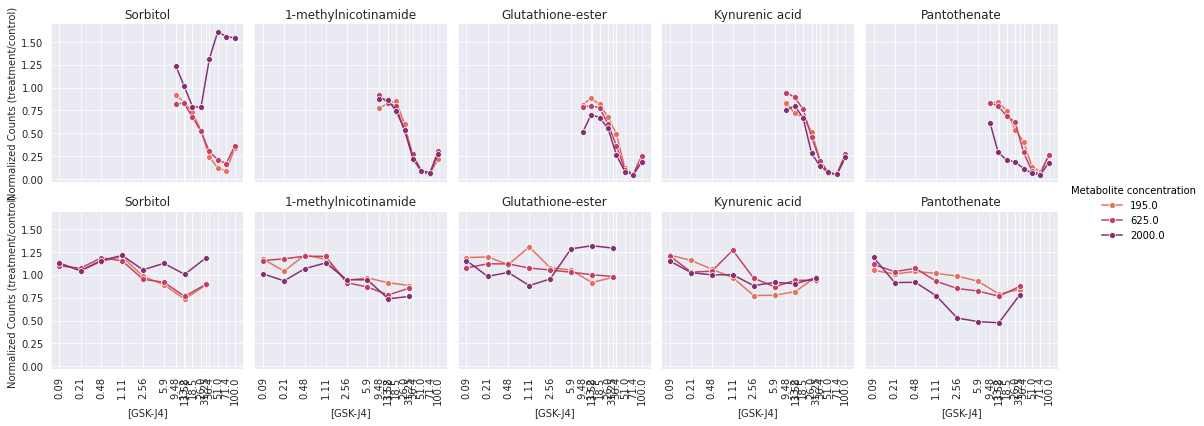

In [31]:
make_static_dose_curve(DrugOnlyDF, yaxis_label='Normalized Counts (treatment/control)', var_to_visualize='Normalized Counts (treatment/control)')

### B. Dose Response Curves with cell counts.
This dose response curve will visualize the cell viability (y-axis) with respect to the concentration of drug (x-axis).

The plot below is the DMSO/Water control norm %

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x00000253853799E0>


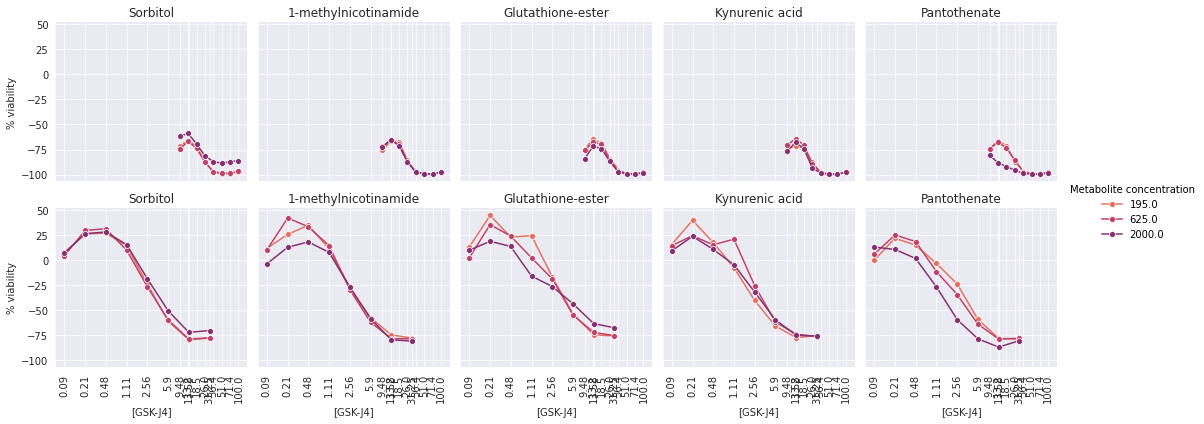

In [32]:
make_static_dose_curve(DMSOWaterDF, yaxis_label='% viability', var_to_visualize='% viability')

Below is normalized by drug.

<generator object make_static_dose_curve.<locals>.<genexpr> at 0x0000025385379580>


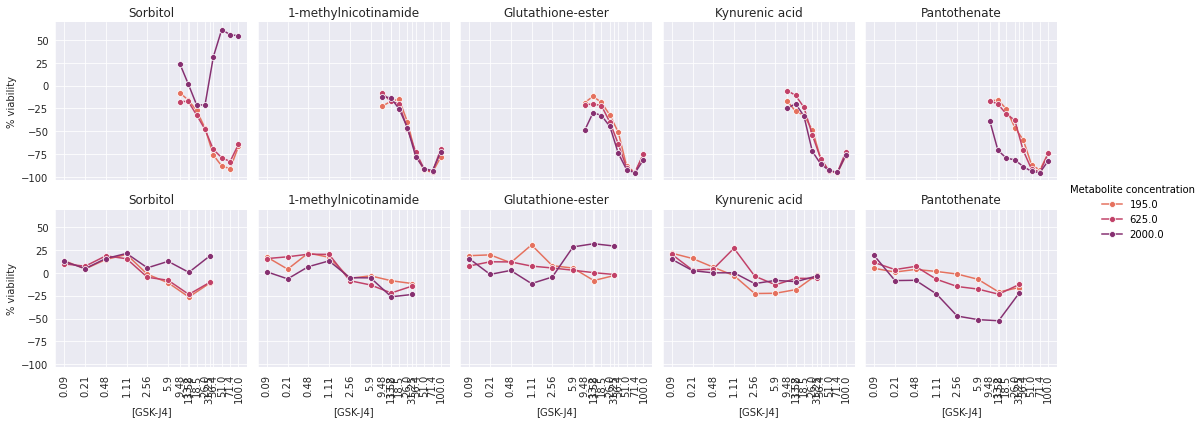

In [33]:
make_static_dose_curve(DrugOnlyDF, yaxis_label='% viability', var_to_visualize='% viability')

### C. Heatmaps

Create a function to generate the labels as a string.

In [34]:
def make_metabolite_conc_labels(df: pd.DataFrame):
    """
    """
    df["Metabolite concentration"] = df["Metabolite concentration"].astype(int)
    df["Metabolite concentration"] = df["Metabolite concentration"].astype(str)
    df["Metabolite concentration"] = df["Metabolite concentration"] + ' uM'

    return df

DrugOnlyDF = make_metabolite_conc_labels(DrugOnlyDF)
DMSOWaterDF = make_metabolite_conc_labels(DMSOWaterDF)

In [35]:
def make_table(df:pd.DataFrame, metabolite_name:str, drug_name:str):
      """
      """
      return df.loc[df["Metabolite"].str.contains(metabolite_name) & 
                           df["Drug"].str.contains(drug_name), :]

def draw_heatmap(df, var_to_visualize, xlabel, ylabel, ax, cmap='rocket_r', center=0, ax_xpos=0, ax_ypos=0, vmax=None, vmin=None, mask=True):
    """
    """
    if mask:
        df[var_to_visualize].loc[df['p-value'] > 0.05] = np.nan
    d = df.pivot(index="Metabolite concentration",
                columns="Drug concentration", 
                values=var_to_visualize)
    d = d.reindex(index=['195 uM', '625 uM', '2000 uM'])
    if mask:
        obj = sns.heatmap(d, 
                cmap=cmap, 
                cbar_kws={'label': ''},
                square=True, annot=True,
                ax=ax[ax_xpos, ax_ypos],
                vmax=vmax, vmin=vmin,
                center=center,
                mask=d.isnull()
                )
    else:
        obj = sns.heatmap(d, 
            cmap=cmap, 
            cbar_kws={'label': ''},
            square=True, annot=True,
            ax=ax[ax_xpos, ax_ypos],
            vmax=vmax, vmin=vmin,
            center=center
            )
    obj.set_facecolor("black")
    obj.invert_yaxis()
    obj.set(xlabel='['+xlabel+']', ylabel='['+ylabel+']')

Below visualizes the drug only normalize dose response matrix.

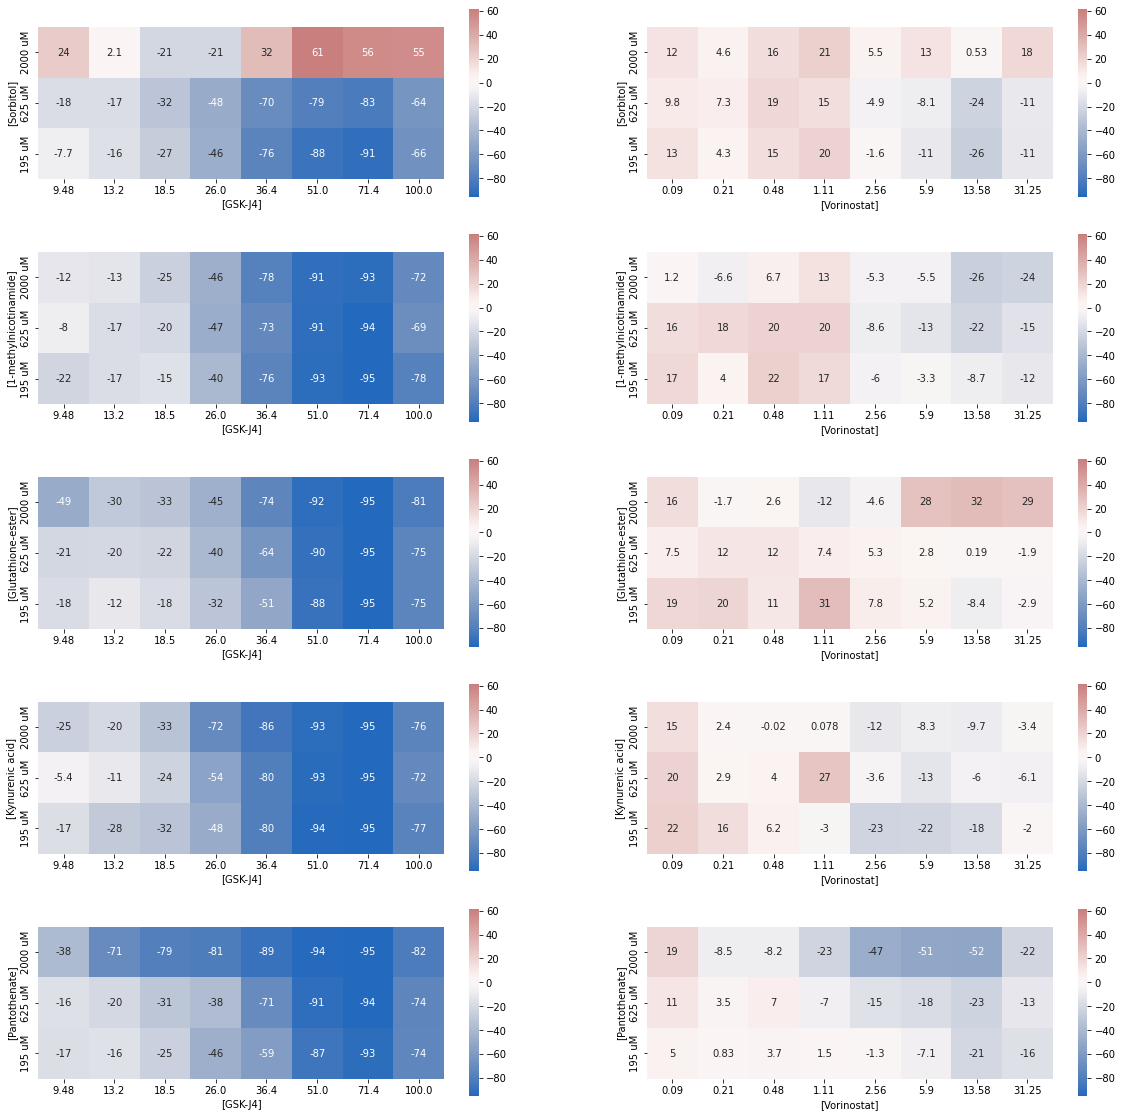

In [36]:
met_to_query = DrugOnlyDF['Metabolite'].unique()
drug_to_query = DrugOnlyDF['Drug'].unique()

max_cc = DrugOnlyDF["% viability"].max()
min_cc = DrugOnlyDF["% viability"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)

for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = DrugOnlyDF.loc[DrugOnlyDF['Metabolite']==metabolite, :]
        tmp = tmp.loc[tmp['Drug']==drug, :]
        value_sort = {'195 uM': 0, '625 uM': 1, '2000 uM': 2}

        tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
        tmp = tmp.sort_values(by='name_sort', ascending=True)

        draw_heatmap(df=tmp, var_to_visualize="% viability", 
                        xlabel=drug, ylabel=metabolite, 
                        ax=axes, cmap='vlag', 
                        center=1,
                        ax_xpos=i, ax_ypos=j, 
                        vmax=max_cc, vmin=min_cc, mask=False)

c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

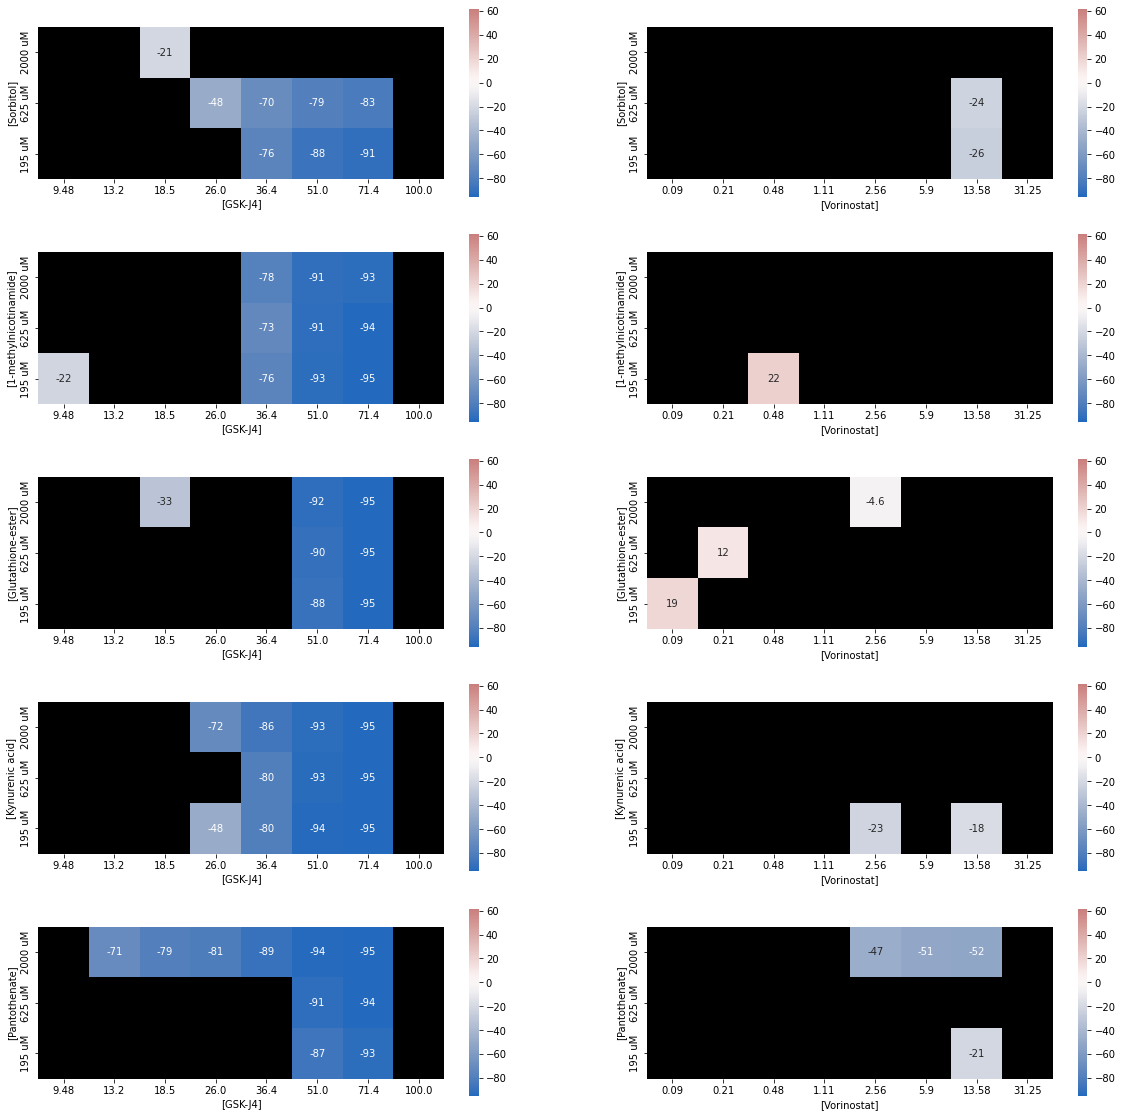

In [37]:
met_to_query = DrugOnlyDF['Metabolite'].unique()
drug_to_query = DrugOnlyDF['Drug'].unique()

max_cc = DrugOnlyDF["% viability"].max()
min_cc = DrugOnlyDF["% viability"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)

for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = DrugOnlyDF.loc[DrugOnlyDF['Metabolite']==metabolite, :]
        tmp = tmp.loc[tmp['Drug']==drug, :]
        value_sort = {'195 uM': 0, '625 uM': 1, '2000 uM': 2}

        tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
        tmp = tmp.sort_values(by='name_sort', ascending=True)

        draw_heatmap(df=tmp, var_to_visualize="% viability", 
                        xlabel=drug, ylabel=metabolite, 
                        ax=axes, cmap='vlag', 
                        center=1,
                        ax_xpos=i, ax_ypos=j, 
                        vmax=max_cc, vmin=min_cc, mask=True)

Below does the DMSO/Water

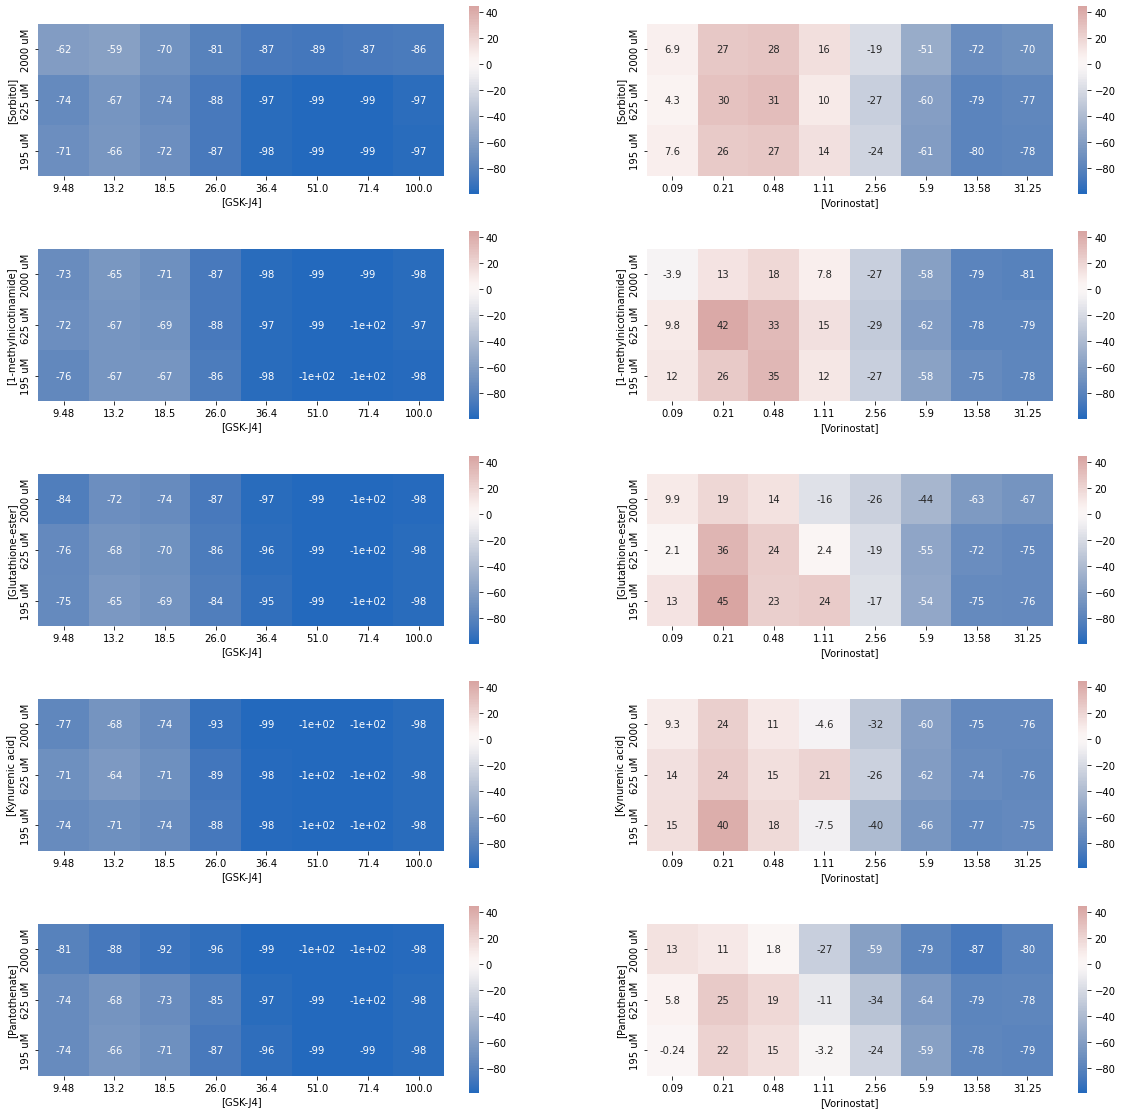

In [38]:
met_to_query = DMSOWaterDF['Metabolite'].unique()
drug_to_query = DMSOWaterDF['Drug'].unique()

max_cc = DMSOWaterDF["% viability"].max()
min_cc = DMSOWaterDF["% viability"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)

for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = DMSOWaterDF.loc[DMSOWaterDF['Metabolite']==metabolite, :]
        tmp = tmp.loc[tmp['Drug']==drug, :]
        value_sort = {'195 uM': 0, '625 uM': 1, '2000 uM': 2}

        tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
        tmp = tmp.sort_values(by='name_sort', ascending=True)

        draw_heatmap(df=tmp, var_to_visualize="% viability", 
                        xlabel=drug, ylabel=metabolite, 
                        ax=axes, cmap='vlag', 
                        center=1,
                        ax_xpos=i, ax_ypos=j, 
                        vmax=max_cc, vmin=min_cc, mask=False)

c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Scott\Envs\drug_analysis\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

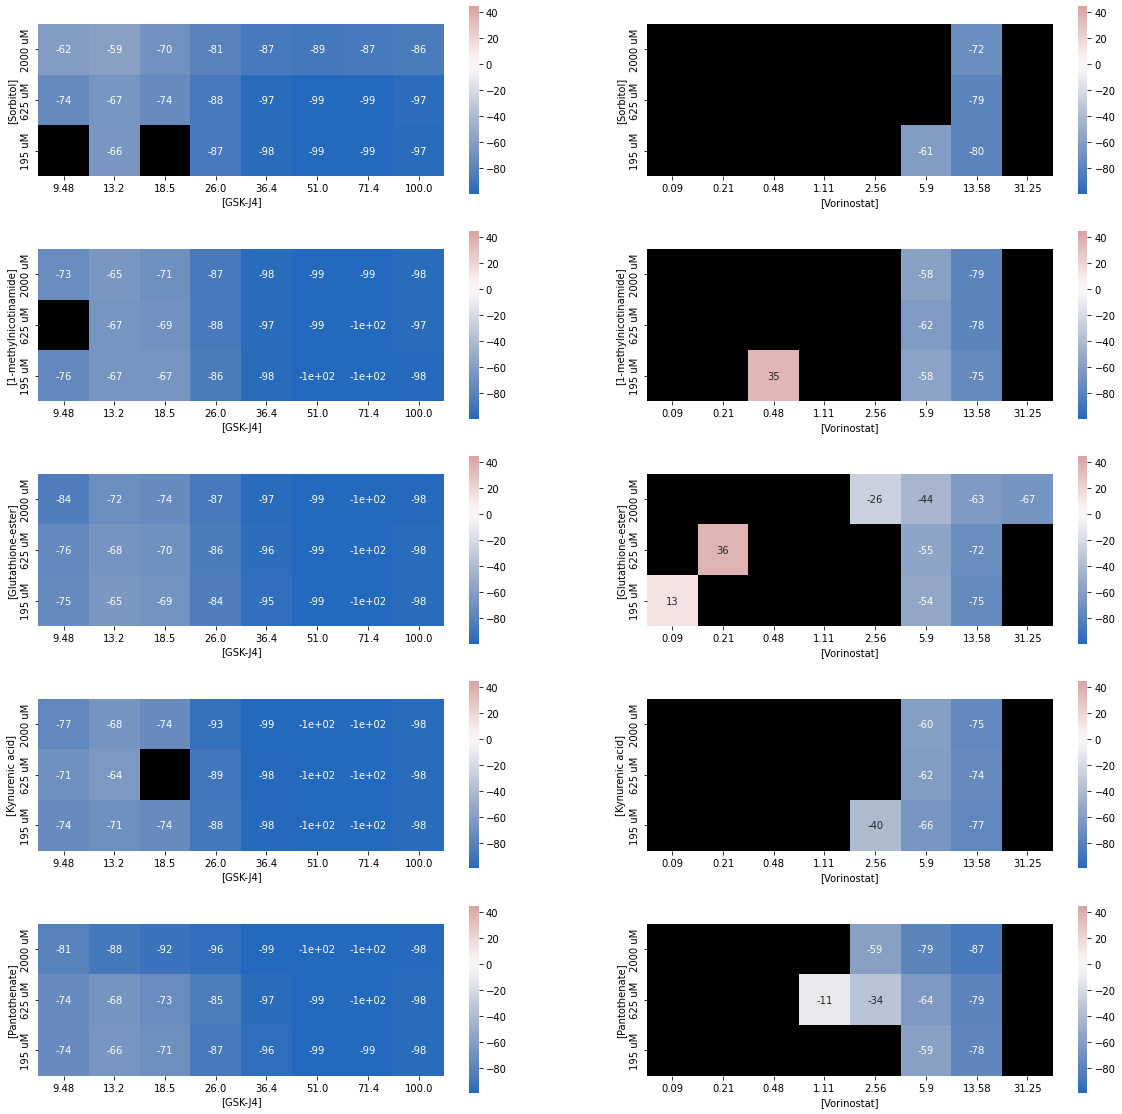

In [39]:
met_to_query = DMSOWaterDF['Metabolite'].unique()
drug_to_query = DMSOWaterDF['Drug'].unique()

max_cc = DMSOWaterDF["% viability"].max()
min_cc = DMSOWaterDF["% viability"].min()

fig, axes = plt.subplots(
    len(met_to_query), len(drug_to_query),
    figsize=(20, 20)
)

for i, metabolite in enumerate(met_to_query):
    for j, drug in enumerate(drug_to_query):
        tmp = DMSOWaterDF.loc[DMSOWaterDF['Metabolite']==metabolite, :]
        tmp = tmp.loc[tmp['Drug']==drug, :]
        value_sort = {'195 uM': 0, '625 uM': 1, '2000 uM': 2}

        tmp['name_sort'] = tmp['Metabolite concentration'].map(value_sort)
        tmp = tmp.sort_values(by='name_sort', ascending=True)

        draw_heatmap(df=tmp, var_to_visualize="% viability", 
                        xlabel=drug, ylabel=metabolite, 
                        ax=axes, cmap='vlag', 
                        center=1,
                        ax_xpos=i, ax_ypos=j, 
                        vmax=max_cc, vmin=min_cc, mask=True)